# Feature Engineering


### Create Aggregate Features


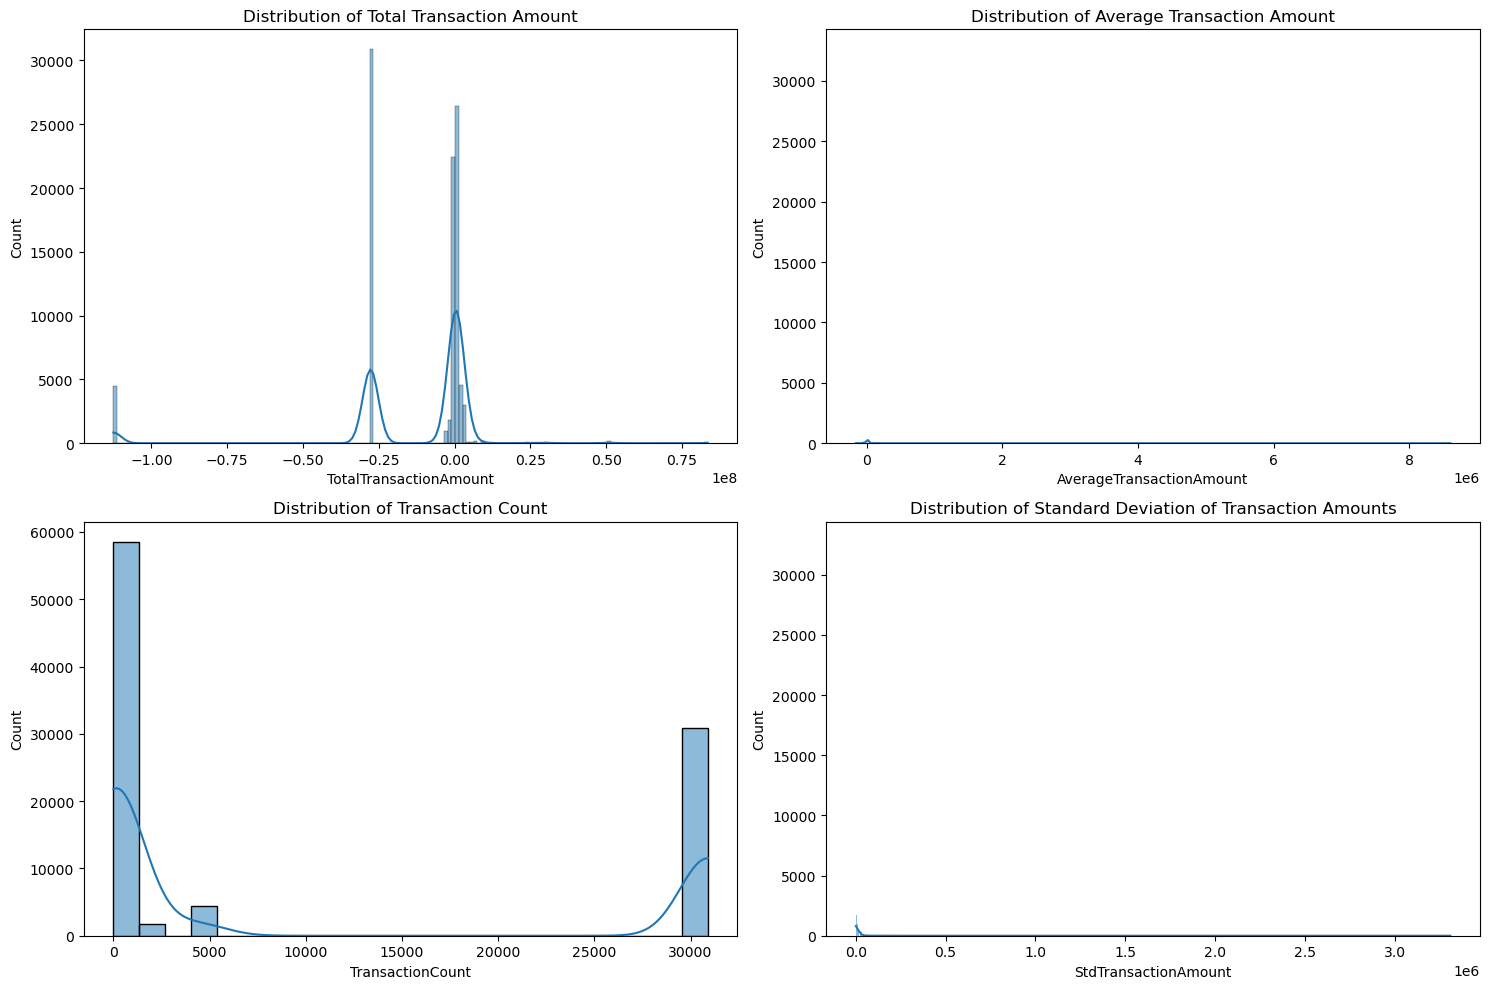

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_csv('../data/data.csv')  # Replace with your actual file path

# Create Aggregate Features
df['TotalTransactionAmount'] = df.groupby('AccountId')['Amount'].transform('sum')
df['AverageTransactionAmount'] = df.groupby('AccountId')['Amount'].transform('mean')
df['TransactionCount'] = df.groupby('AccountId')['TransactionId'].transform('count')
df['StdTransactionAmount'] = df.groupby('AccountId')['Amount'].transform('std')

# Visualize Distributions
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(df['TotalTransactionAmount'], kde=True)
plt.title('Distribution of Total Transaction Amount')

plt.subplot(2, 2, 2)
sns.histplot(df['AverageTransactionAmount'], kde=True)
plt.title('Distribution of Average Transaction Amount')

plt.subplot(2, 2, 3)
sns.histplot(df['TransactionCount'], kde=True)
plt.title('Distribution of Transaction Count')

plt.subplot(2, 2, 4)
sns.histplot(df['StdTransactionAmount'], kde=True)
plt.title('Distribution of Standard Deviation of Transaction Amounts')

plt.tight_layout()
plt.show()

### Extract Features

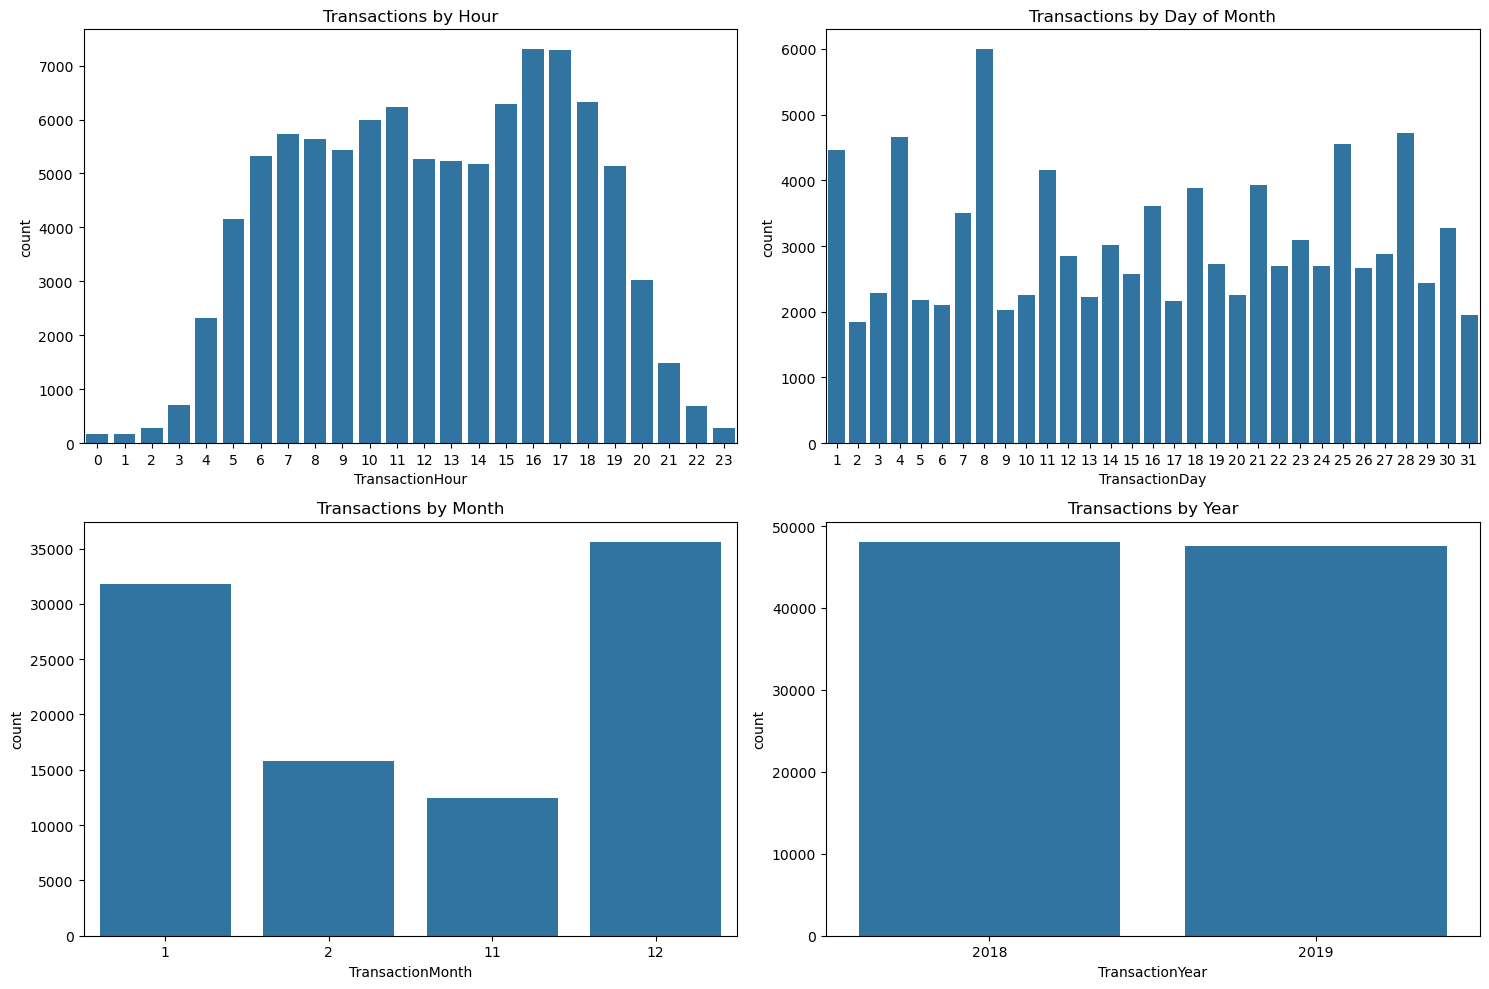

In [7]:
from datetime import datetime

# Convert to datetime if not already done
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

# Extract time features
df['TransactionHour'] = df['TransactionStartTime'].dt.hour
df['TransactionDay'] = df['TransactionStartTime'].dt.day
df['TransactionMonth'] = df['TransactionStartTime'].dt.month
df['TransactionYear'] = df['TransactionStartTime'].dt.year

# Visualize extracted features
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.countplot(x='TransactionHour', data=df)
plt.title('Transactions by Hour')

plt.subplot(2, 2, 2)
sns.countplot(x='TransactionDay', data=df)
plt.title('Transactions by Day of Month')

plt.subplot(2, 2, 3)
sns.countplot(x='TransactionMonth', data=df)
plt.title('Transactions by Month')

plt.subplot(2, 2, 4)
sns.countplot(x='TransactionYear', data=df)
plt.title('Transactions by Year')

plt.tight_layout()
plt.show()

### Encode Categorical Variables

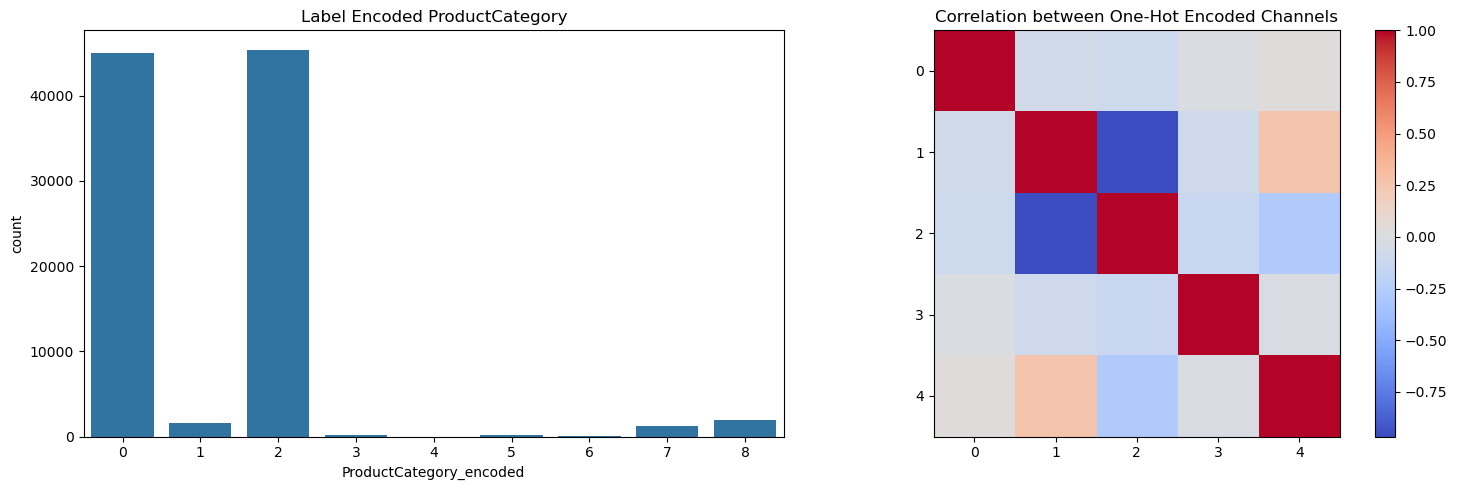

In [8]:
# One-Hot Encoding for 'ChannelId'
df = pd.get_dummies(df, columns=['ChannelId'], prefix=['Channel'])

# Label Encoding for 'ProductCategory'
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['ProductCategory_encoded'] = le.fit_transform(df['ProductCategory'])

# Visualize Encoded Features
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='ProductCategory_encoded', data=df)
plt.title('Label Encoded ProductCategory')

plt.subplot(1, 2, 2)
plt.imshow(df.iloc[:, -5:].corr(), cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Correlation between One-Hot Encoded Channels')
plt.tight_layout()
plt.show()

### Handle Missing Values

TransactionId                 0
BatchId                       0
AccountId                     0
SubscriptionId                0
CustomerId                    0
CurrencyCode                  0
CountryCode                   0
ProviderId                    0
ProductId                     0
ProductCategory               0
Amount                        0
Value                         0
TransactionStartTime          0
PricingStrategy               0
FraudResult                   0
TotalTransactionAmount        0
AverageTransactionAmount      0
TransactionCount              0
StdTransactionAmount        812
TransactionHour               0
TransactionDay                0
TransactionMonth              0
TransactionYear               0
Channel_ChannelId_1           0
Channel_ChannelId_2           0
Channel_ChannelId_3           0
Channel_ChannelId_5           0
ProductCategory_encoded       0
dtype: int64


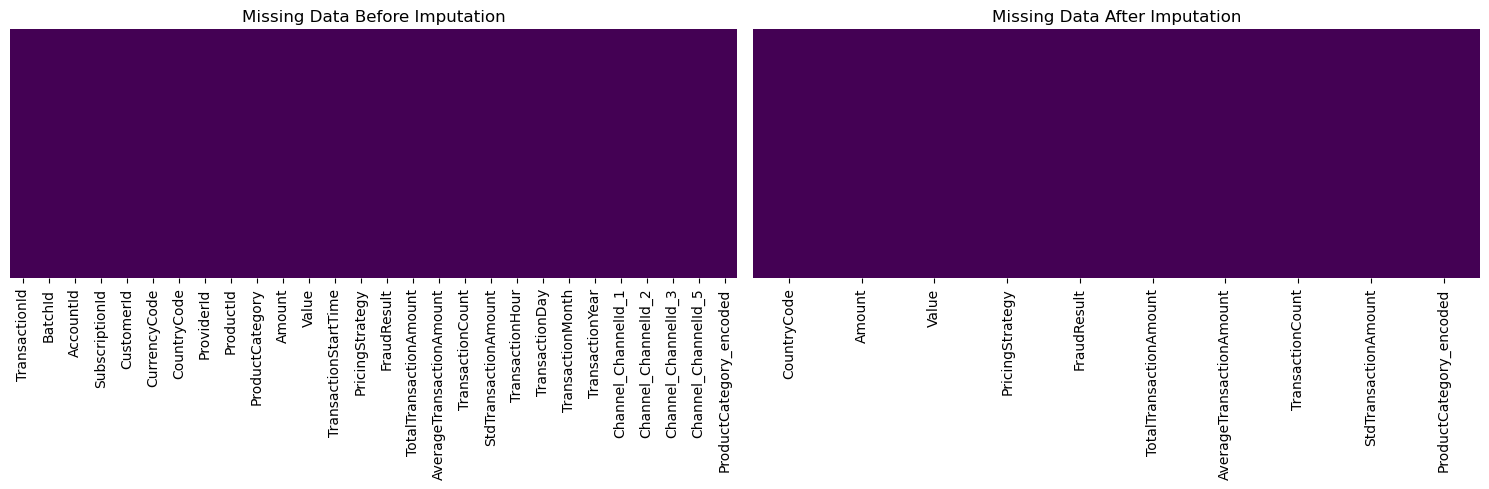

In [9]:
from sklearn.impute import SimpleImputer

# Identify missing values
print(df.isnull().sum())

# Imputation for numerical data
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='mean')
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

# For categorical data, we'll use mode imputation or removal
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Visualize before and after imputation
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data Before Imputation')

plt.subplot(1, 2, 2)
sns.heatmap(df[numerical_cols].isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data After Imputation')

plt.tight_layout()
plt.show()

###  Normalize/Standardize Numerical Features

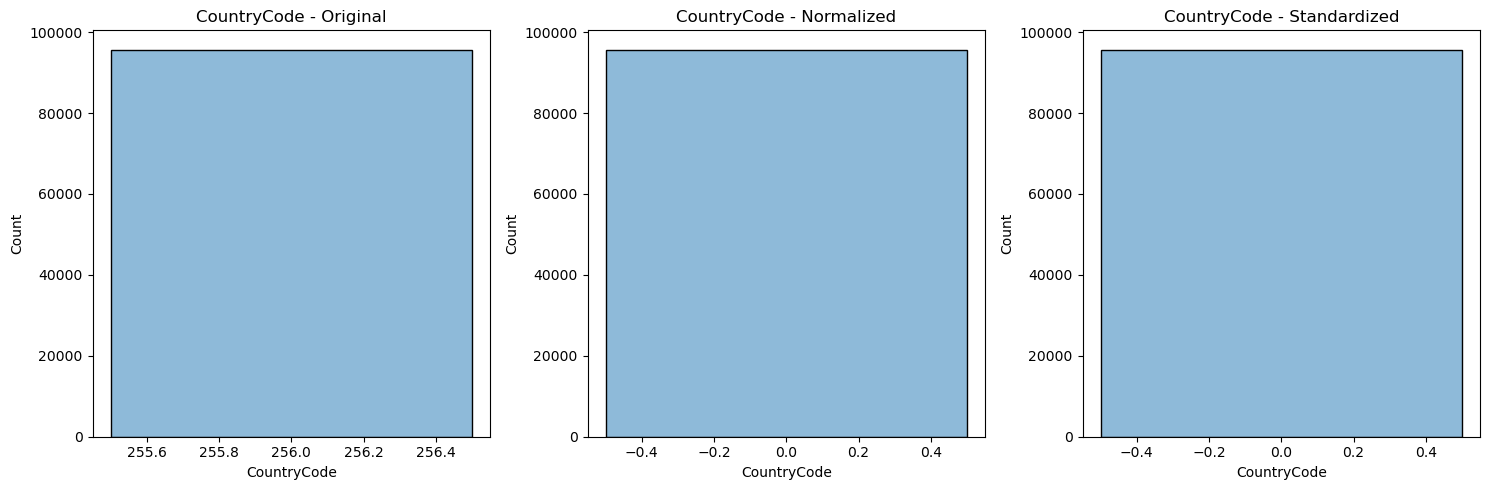

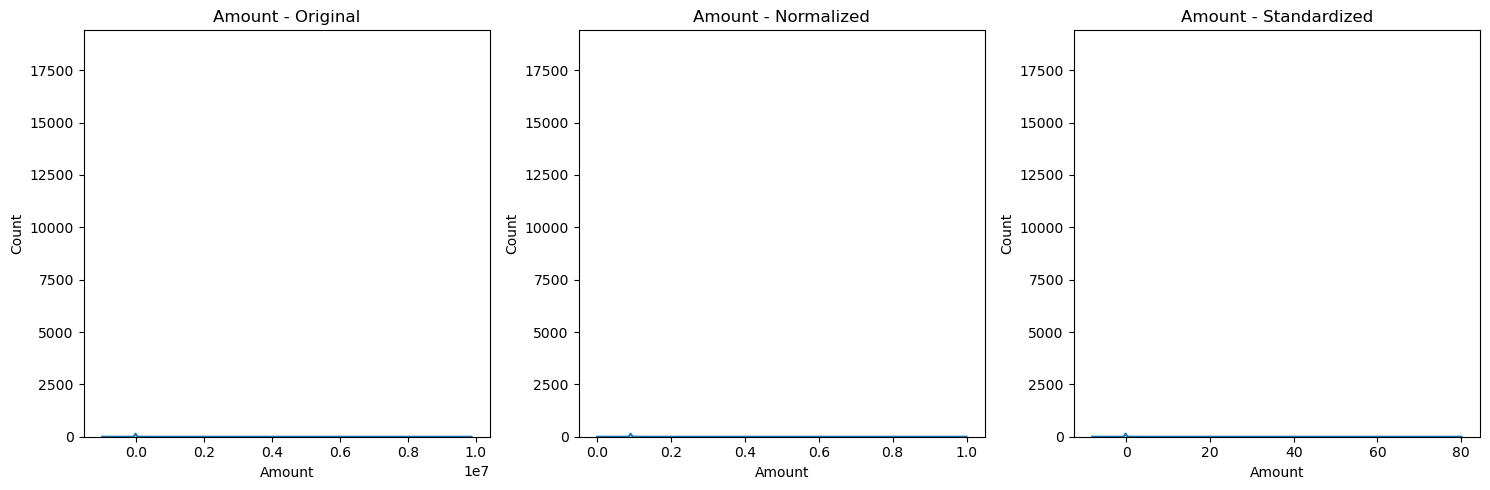

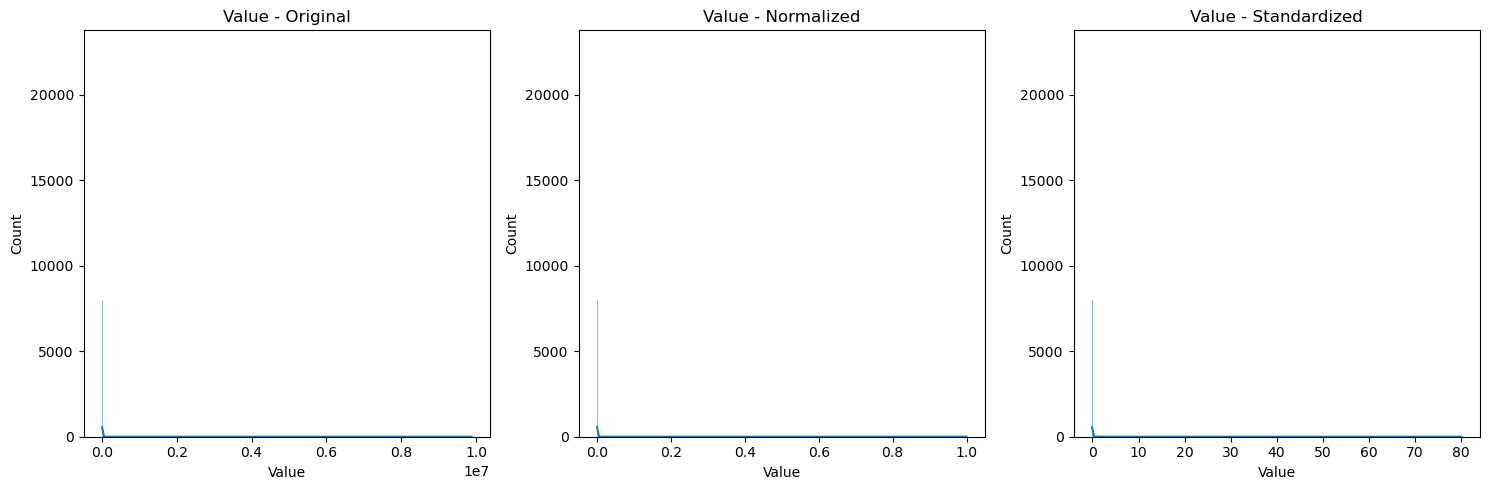

In [15]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Normalization
normalizer = MinMaxScaler()
df_normalized = df.copy()
df_normalized[numerical_cols] = normalizer.fit_transform(df[numerical_cols])

# Standardization
scaler = StandardScaler()
df_standardized = df.copy()
df_standardized[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Visualize before and after scaling
for col in numerical_cols[:3]:  # Example with first three numerical columns
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'{col} - Original')
    
    plt.subplot(1, 3, 2)
    sns.histplot(df_normalized[col], kde=True)
    plt.title(f'{col} - Normalized')
    
    plt.subplot(1, 3, 3)
    sns.histplot(df_standardized[col], kde=True)
    plt.title(f'{col} - Standardized')
    
    plt.tight_layout()
    plt.show()

### Manual WOE Calculation and Encoding

WOE and IV for ProductCategory:
                          WOE        IV
airtime             -1.620379  1.377865
financial_services   0.565446  1.377865
utility_bill         1.134962  1.377865
data_bundles       -13.815511  1.377865
tv                 -13.815511  1.377865
transport            3.761520  1.377865
ticket             -13.815511  1.377865
movies             -13.815511  1.377865
other              -13.815511  1.377865


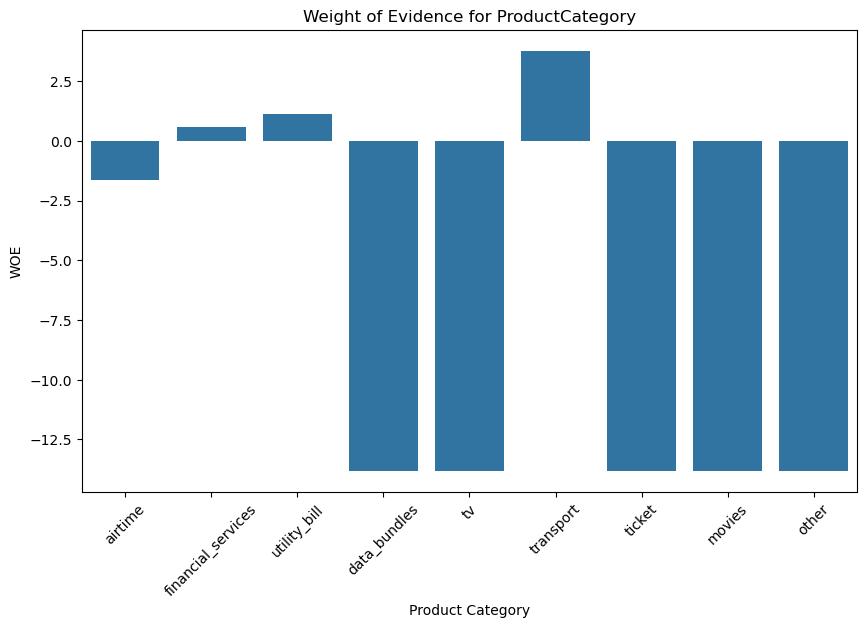

Information Value for ProductCategory: 12.400782322220023


In [ ]:
def safe_log(x):
    return np.log(np.maximum(x, 1e-6))  # 1e-6 is an example of a small value to avoid log(0)

def woe_iv(X, y, event=1):
    def _woe(X, y, event):
        d1 = pd.DataFrame({'X': X, 'Y': y})
        n = d1.shape[0]
        good = (d1['Y'] == event).sum()
        bad = n - good
        g = d1[d1['Y'] == event].groupby('X').size().reindex(X.unique(), fill_value=0)
        b = d1[d1['Y'] != event].groupby('X').size().reindex(X.unique(), fill_value=0)
        
        categories = X.unique()
        g1 = g.values
        b1 = b.values

        # Use safe_log to handle zero counts
        with np.errstate(divide='ignore', invalid='ignore'):
            woe = safe_log((g1 / good) / (b1 / bad))
        
        # Handle cases where both g1 and b1 are zero
        woe = np.where((g1 == 0) & (b1 == 0), 0, woe)
        
        return woe, categories

    woe, index = _woe(X, y, event)
    g = X[y == event].value_counts().reindex(index, fill_value=0)
    b = X[y != event].value_counts().reindex(index, fill_value=0)
    
    good = (y == event).sum()
    bad = len(y) - good
    
    # Handle potential division by zero in IV calculation
    with np.errstate(divide='ignore', invalid='ignore'):
        iv = ((g / good - b / bad) * woe).sum()
    
    # If IV is infinite, set it to a very high number or handle it as you see fit
    iv = np.where(np.isinf(iv), np.sign(iv) * 1e10, iv)  # 1e10 is arbitrary, adjust as needed
    
    df = pd.DataFrame({'WOE': woe, 'IV': iv}, index=index)
    return df
# Assuming 'FraudResult' is your binary target variable (1 for event, 0 for non-event)
# and 'ProductCategory' is a categorical feature you want to encode with WOE
X = df['ProductCategory']
y = df['FraudResult']

woe_df = woe_iv(X, y)
print("WOE and IV for ProductCategory:")
print(woe_df)

# Merge WOE back into the dataframe
df = df.merge(woe_df['WOE'], left_on='ProductCategory', right_index=True, how='left', suffixes=('', '_WOE'))

# Visualization of WOE
plt.figure(figsize=(10, 6))
sns.barplot(x=woe_df.index, y=woe_df['WOE'])
plt.title('Weight of Evidence for ProductCategory')
plt.xlabel('Product Category')
plt.ylabel('WOE')
plt.xticks(rotation=45)
plt.show()

# Information Value (IV) for feature selection
print(f"Information Value for ProductCategory: {woe_df['IV'].sum()}")